                                Mini Project 12_ANN (Heart Failure Prediction)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, mutual_info_score
import xgboost as xgb

%matplotlib inline
plt.rcParams.update({"font.size": 13, "figure.figsize": [8,4]})

# 1. Read Dataset

In [2]:
# Read the dataset
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Here, the target variable is `DEATH_EVENT`. That means, it is a binary classification problem.

# 2. Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


From dataset description, we can see that:
- The shape of the dataset is (299, 13). 
- There are no missing values.
- The data type of `age` is float. We'll convert it to integer.

In [4]:
df["age"] = df["age"].astype(int)

In [5]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.829431,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894997,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


From dataset description, we can see that:
- `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, `smoking` and `DEATH_EVENT` are qualitative variables. One easy way to find out is to check the min and max values of those variables. We need to decode these variables.
- The rest are quantitative variables.
- Age is distributed between 40 to 95.

In [6]:
df["DEATH_EVENT"].value_counts(normalize=True)

0    0.67893
1    0.32107
Name: DEATH_EVENT, dtype: float64

We have approximately 68% False and 32% True values for DEATH_EVENT.

In [7]:
df["sex"].value_counts(normalize=True)

1    0.648829
0    0.351171
Name: sex, dtype: float64

We have approximately 65% Male and 35% Female in the dataset.

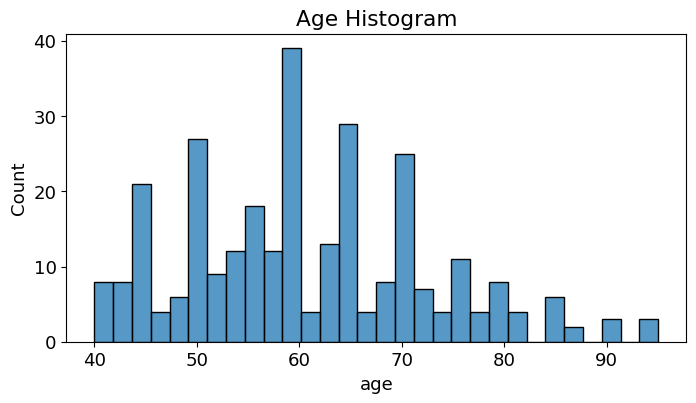

In [8]:
sns.histplot(df["age"], bins=30)
plt.title("Age Histogram")
plt.show()

For age, the median is around 60.

## 2.1 Feature Importance

### 2.1.1 Mutual Information

In [9]:
def mutual_info_death_event(series):
    return mutual_info_score(series, df["DEATH_EVENT"])

In [10]:
# Only select that columns with discrete values
mi = df[df.columns.difference(["platelets", "serum_creatinine", "DEATH_EVENT"])].apply(mutual_info_death_event)
mi.sort_values(ascending=False)

time                        0.514155
creatinine_phosphokinase    0.443626
age                         0.137379
ejection_fraction           0.114313
serum_sodium                0.083258
high_blood_pressure         0.003115
anaemia                     0.002188
smoking                     0.000080
sex                         0.000009
diabetes                    0.000002
dtype: float64

We can see that `time` has best mutual information score with `DEATH_EVENT`.

### 2.1.2 Correlation

In [11]:
corr = df[df.columns.difference(["DEATH_EVENT"])].corrwith(df["DEATH_EVENT"]).abs()
corr.sort_values(ascending=False)

time                        0.526964
serum_creatinine            0.294278
ejection_fraction           0.268603
age                         0.253581
serum_sodium                0.195204
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
platelets                   0.049139
smoking                     0.012623
sex                         0.004316
diabetes                    0.001943
dtype: float64

We can see that again `time` has the best correlation with `DEATH_EVENT` followed by `serum_creatinine` and `ejection_fraction`.

# 3. Data Preprocessing

## 3.1 Decode Qualitative Variables

Decode the qualitative variables:

In [12]:
binary_values = {
    0: True,
    1: False
}
df["diabetes"] = df["diabetes"].map(binary_values)
df["high_blood_pressure"] = df["high_blood_pressure"].map(binary_values)
df["smoking"] = df["smoking"].map(binary_values)
df["DEATH_EVENT"] = df["DEATH_EVENT"].map(binary_values)
df["anaemia"] = df["anaemia"].map(binary_values)

sex_values = {
    0: "female",
    1: "male"
}
df["sex"] = df["sex"].map(sex_values)

## 3.2 Split Dataset into Train, Validation and Test Data

In [13]:
# Split the data in train/val/test sets, with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["DEATH_EVENT"].values
y_val = df_val["DEATH_EVENT"].values
y_test = df_test["DEATH_EVENT"].values

# Delete target variable `price` from the dataframes
del df_train["DEATH_EVENT"]
del df_val["DEATH_EVENT"]
del df_test["DEATH_EVENT"]

## 3.3 Apply One Hot Encoding

In [14]:
# Apply one hot encoding to categorical variables
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient="records")
X_val = dv.fit_transform(val_dict)

test_dict = df_test.to_dict(orient="records")
X_test = dv.fit_transform(test_dict)

In [15]:
# Display the feature names after encoding
dv.get_feature_names_out()

array(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex=female', 'sex=male',
       'smoking', 'time'], dtype=object)

# 4. Model Training

In this section, we are going to train four different classification models, tune hyperparameters and finally selecting the best model.

## 4.1 LogisticRegression Model

### 4.1.1 Base Model

In [16]:
# Train the model with training dataset
lr_base = LogisticRegression(random_state=1)
lr_base.fit(X_train, y_train)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [17]:
print(f"Model intercept: {lr_base.intercept_[0].round(5)}")
print(f"Model coefficients: {dict(zip(dv.get_feature_names_out(), lr_base.coef_[0].round(5)))}")

Model intercept: -0.00033
Model coefficients: {'age': -0.05973, 'anaemia': -0.00248, 'creatinine_phosphokinase': -0.00024, 'diabetes': -2e-05, 'ejection_fraction': 0.05842, 'high_blood_pressure': -0.00099, 'platelets': 0.0, 'serum_creatinine': -0.02385, 'serum_sodium': 0.00214, 'sex=female': 0.00073, 'sex=male': -0.00106, 'smoking': -0.00015, 'time': 0.01736}


In [18]:
# Predict using validation dataset
y_pred = lr_base.predict_proba(X_val)[:, 1]
result = (y_pred >= 0.5)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred).round(3)}")

Validation dataset AUC: 0.831


In [19]:
# Predict using training dataset
y_pred = lr_base.predict_proba(X_train)[:, 1]
result = (y_pred >= 0.5)
print(f"Training set AUC: {roc_auc_score(y_train, y_pred).round(3)}")

Training set AUC: 0.862


By comparing the training and validation dataset AUC, we can say that the model is not overfitted. Now let's try to improve the model by tuning the hyperparameters.

### 4.1.2 Tune Hyperparameters using GridSearchCV

In [20]:
# Define the parameter grid
param_grid = {
    "C": np.logspace(-3,3,20)
}

# Define the grid search model
lr = LogisticRegression(random_state=1)
search_lr = GridSearchCV(
    estimator=lr, 
    param_grid=param_grid, 
    n_jobs=-1
)
# By default it uses 5 fold

# Train the grid search model with training dataset
search_lr.fit(X_train, y_train)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])})

In [21]:
# Get the tuned hyperparameters from the grid search model
print(f"Best parameter (CV Score = {search_lr.best_score_.round(3)}):")
print(search_lr.best_params_)

Best parameter (CV Score = 0.816):
{'C': 0.00206913808111479}


Now, let's create a tuned model with best hyperparameter.

### 4.1.3 Tuned Model

In [22]:
# Train the model with training dataset
lr_tuned = LogisticRegression(C=0.078476, random_state=1)
lr_tuned.fit(X_train, y_train)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.078476, random_state=1)

In [23]:
print(f"Model intercept: {lr_tuned.intercept_[0].round(5)}")
print(f"Model coefficients: {dict(zip(dv.get_feature_names_out(), lr_tuned.coef_[0].round(5)))}")

Model intercept: -0.00018
Model coefficients: {'age': -0.04737, 'anaemia': -0.00065, 'creatinine_phosphokinase': -0.00021, 'diabetes': -0.00025, 'ejection_fraction': 0.06302, 'high_blood_pressure': -0.00019, 'platelets': 0.0, 'serum_creatinine': -0.0083, 'serum_sodium': -0.00556, 'sex=female': 0.00079, 'sex=male': -0.00097, 'smoking': 8e-05, 'time': 0.01759}


In [24]:
# Predict using validation dataset
y_pred = lr_tuned.predict_proba(X_val)[:,1]
result = (y_pred >= 0.5)
print(f"AUC: {roc_auc_score(y_val, y_pred).round(3)}")

AUC: 0.84


For classification tasks, we can not only rely on the accuracy of the model, specially when the dataset is imbalanced. In our dataset, we have more True outputs than False. So, we need to check other metrics as well.

### 4.1.4 Model Interpretation

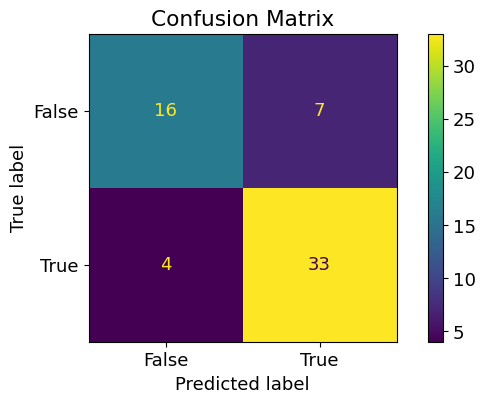

In [25]:
# Calculate the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, result)
plt.title("Confusion Matrix")
plt.show()

In our validation dataset, we have total 60 records where 23 records have False outcome and 37 records have True outcome. But our model predicted 20 False and 40 True outcomes. Let's use different threshold values and check how the model performs.

In [26]:
# Iterate over different threshold values, calculate precision and recall 
thresholds = np.arange(0, 1.01, 0.01)

scores = []
for t in thresholds:
    result = (y_pred >= t)
    fn = confusion_matrix(y_val, result)[1][0]
    precision = precision_score(y_val, result, zero_division=0).round(3)
    recall = recall_score(y_val, result, zero_division=0).round(3)
    scores.append((t, fn, precision, recall))

df_scores = pd.DataFrame(scores, columns=["threshold", "FN", "precision", "recall"])
df_scores

,threshold,FN,precision,recall
0,0.00,0,0.617,1.000
1,0.01,0,0.617,1.000
2,0.02,0,0.617,1.000
3,0.03,0,0.617,1.000
4,0.04,0,0.617,1.000
...,...,...,...,...
96,0.96,36,1.000,0.027
97,0.97,36,1.000,0.027
98,0.98,37,0.000,0.000
99,0.99,37,0.000,0.000


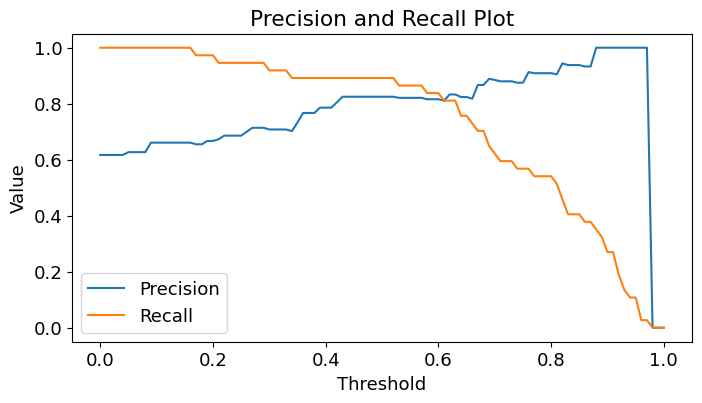

In [27]:
# Draw precision and recall plot
plt.plot(df_scores["threshold"], df_scores["precision"], label="Precision")
plt.plot(df_scores["threshold"], df_scores["recall"], label="Recall")
plt.title("Precision and Recall Plot")
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.legend()
plt.draw()

From the plot, we can see that threshold = 0.6 would be ideal for the model.

### 4.1.5 Final Model

Now again, let's train the model again with threshold 0.6.

In [28]:
# Train the model with training dataset
lr_final = LogisticRegression(C=0.078476, random_state=1)
lr_final.fit(X_train, y_train)

# Predict using validation dataset
y_pred = lr_final.predict_proba(X_val)[:,1]
result = (y_pred >= 0.6)
print(f"AUC: {roc_auc_score(y_val, y_pred).round(3)}")

AUC: 0.84


C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


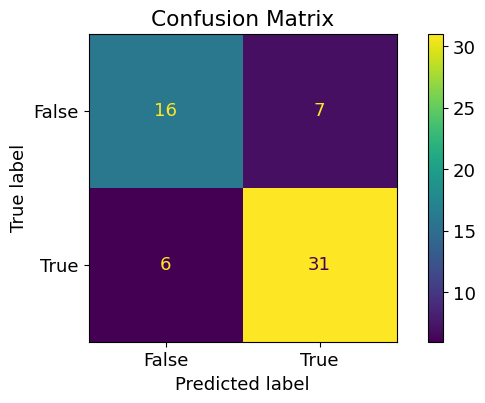

In [29]:
# Calculate the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, result)
plt.title("Confusion Matrix")
plt.show()

## 4.2 DecisionTreeClassifier Model

### 4.2.1 Base Model

In [30]:
# Train the model with training dataset using default parameters
dt_base = DecisionTreeClassifier(random_state=1)
dt_base.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [31]:
# Predict using validation dataset
y_pred = dt_base.predict_proba(X_val)[:, 1]
result = (y_pred >= 0.5)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred).round(3)}")

Validation dataset AUC: 0.791


In [32]:
# Predict using training dataset
y_pred = dt_base.predict_proba(X_train)[:, 1]
result = (y_pred >= 0.5)
print(f"Training dataset AUC: {roc_auc_score(y_train, y_pred).round(3)}")

Training dataset AUC: 1.0


By comparing the AUC of training and validation dataset, we can see that our DecisionTreeClassifier model is overfitted for training datset as the AUC is 1.0. The reason is we trained the model with default parameters. Now let's try to improve the model by tuning these default parameters. For this, again we are going to use GridSearchCV.

### 4.2.2 Tune Hyperparameters using GridSearchCV

In [33]:
# Define the parameter grid
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter":["best", "random"],
    "max_depth": [None, 3, 4, 5, 6, 7, 8, 9, 10],
    "max_features":[None, 3, 5, 7, 9, 11],
    "min_samples_leaf": [2, 3, 5, 7, 9, 11],
    "min_samples_split": [2, 3, 5, 7, 9, 11, 13, 15]
}

In [34]:
# Define the grid search model
dt = DecisionTreeClassifier(random_state=1)
search_dt = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    n_jobs=-1
)

# Train the grid search model with training dataset
search_dt.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [None, 3, 5, 7, 9, 11],
                         'min_samples_leaf': [2, 3, 5, 7, 9, 11],
                         'min_samples_split': [2, 3, 5, 7, 9, 11, 13, 15],
                         'splitter': ['best', 'random']})

In [35]:
# Get the tuned hyperparameters from the grid search model
print(f"Best parameter (CV Score = {search_dt.best_score_.round(3)}):")
print(search_dt.best_params_)

Best parameter (CV Score = 0.843):
{'criterion': 'gini', 'max_depth': 6, 'max_features': 9, 'min_samples_leaf': 3, 'min_samples_split': 13, 'splitter': 'random'}


Now, let's create a tuned model with best hyperparameters.

### 4.2.3 Tuned Model

In [36]:
# Train the model again with tuned parameters
dt_tuned = DecisionTreeClassifier(
    criterion="gini", 
    max_depth=6, 
    max_features=9, 
    min_samples_leaf=3, 
    min_samples_split=13, 
    splitter="random", 
    random_state=1
)
dt_tuned.fit(X_train, y_train)

# Predit using validation dataset
y_pred_val = dt_tuned.predict_proba(X_val)[:, 1]
result = (y_pred_val >= 0.5)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred_val).round(3)}")

Validation dataset AUC: 0.858


In [37]:
# Predict using training dataset
y_pred_train = dt_tuned.predict_proba(X_train)[:, 1]
result = (y_pred_train >= 0.5)
print(f"Training dataset AUC: {roc_auc_score(y_train, y_pred_train).round(3)}")

Training dataset AUC: 0.909


### 4.2.4 Model Interpretation

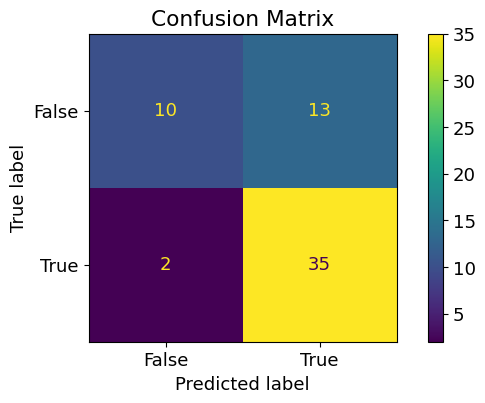

In [38]:
result = (y_pred_val >= 0.5)
ConfusionMatrixDisplay.from_predictions(y_val, result)
plt.title("Confusion Matrix")
plt.show()

Again, let's use different threshold values and check how the model performs.

In [39]:
# Iterate over different threshold values, calculate precision and recall 
thresholds = np.arange(0, 1.01, 0.01)

scores = []
for t in thresholds:
    result = (y_pred_val >= t)
    fn = confusion_matrix(y_val, result)[1][0]
    precision = precision_score(y_val, result, zero_division=0).round(3)
    recall = recall_score(y_val, result, zero_division=0).round(3)
    scores.append((t, fn, precision, recall))

df_scores = pd.DataFrame(scores, columns=["threshold", "FN", "precision", "recall"])
df_scores

,threshold,FN,precision,recall
0,0.00,0,0.617,1.000
1,0.01,0,0.712,1.000
2,0.02,0,0.712,1.000
3,0.03,0,0.712,1.000
4,0.04,0,0.712,1.000
...,...,...,...,...
96,0.96,30,0.875,0.189
97,0.97,30,0.875,0.189
98,0.98,30,0.875,0.189
99,0.99,30,0.875,0.189


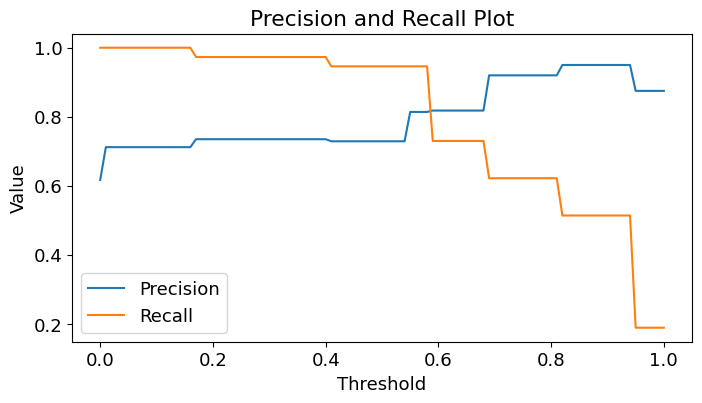

In [40]:
# Draw precisiona and recall plot
plt.plot(df_scores["threshold"], df_scores["precision"], label="Precision")
plt.plot(df_scores["threshold"], df_scores["recall"], label="Recall")
plt.title("Precision and Recall Plot")
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.legend()
plt.draw()

From the plot, we see that threshold = 0.6 would be ideal for the model.

### 4.2.5 Final Model

In [41]:
# Train the model with training dataset using default parameters
dt_final = DecisionTreeClassifier(
    criterion="gini", 
    max_depth=6, 
    max_features=9, 
    min_samples_leaf=3, 
    min_samples_split=13, 
    splitter="random", 
    random_state=1
)
dt_final.fit(X_train, y_train)

# Predict using validation dataset
y_pred = dt_final.predict_proba(X_val)[:, 1]
result = (y_pred >= 0.6)
print(f"AUC: {roc_auc_score(y_val, y_pred).round(3)}")

AUC: 0.858


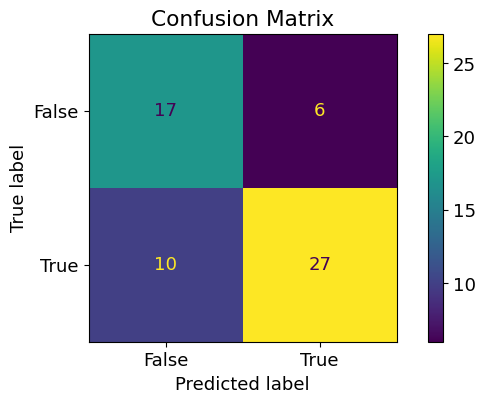

In [42]:
# Calculate the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, result)
plt.title("Confusion Matrix")
plt.show()

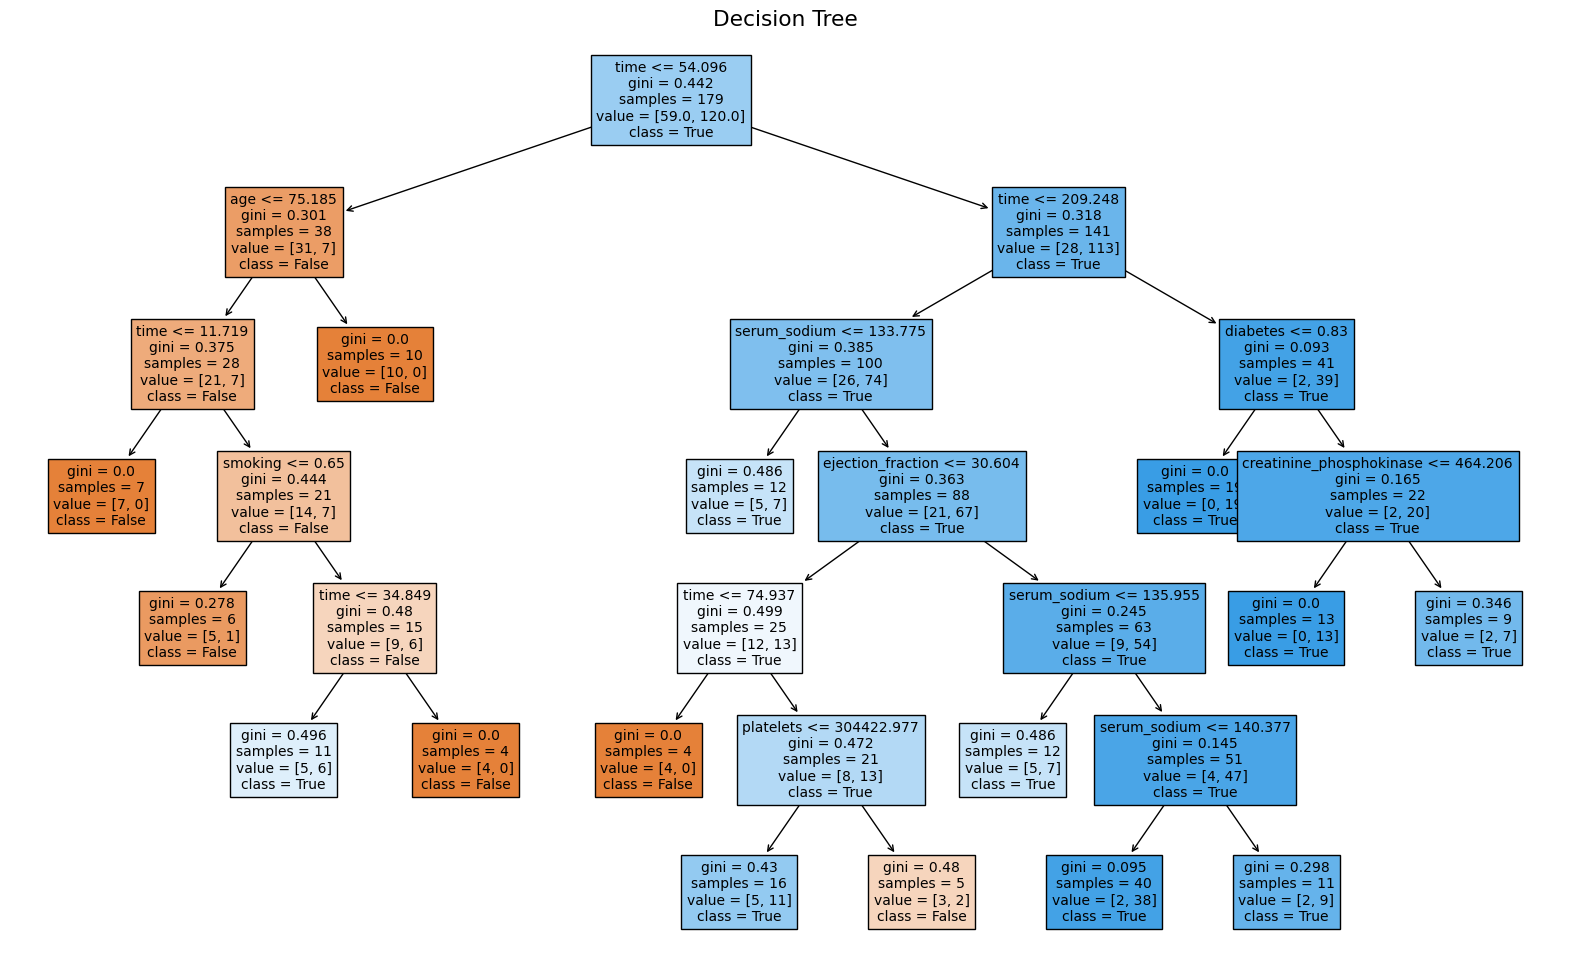

In [43]:
# Plot the final decision tree
feature_names = list(dv.get_feature_names_out())
class_names = list(map(str, df["DEATH_EVENT"].unique()))

plt.figure(figsize=(20,12), dpi=100)
plot_tree(dt_final, feature_names=feature_names, class_names=class_names, filled=True, fontsize=10)
plt.title("Decision Tree")
plt.show()
# Double click to zoom the plot

In [44]:
# Check important features
importances = dt_final.feature_importances_
importances

array([0.02254199, 0.        , 0.01285511, 0.00412425, 0.09957803,
       0.        , 0.01541289, 0.        , 0.07811917, 0.        ,
       0.        , 0.01142127, 0.75594729])

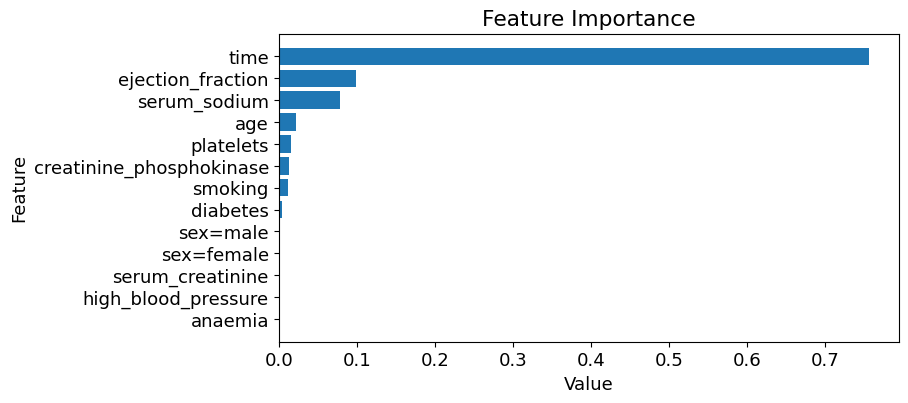

In [45]:
# Draw the important featuers in a plot
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(dv.get_feature_names_out()[indices])
plt.title("Feature Importance")
plt.xlabel("Value")
plt.ylabel("Feature")
plt.show()

We can see that `time` is the most important feature followed by `ejection_fraction` and `serum_sodium`. From correlation score also, we got similar result.

## 4.3 RandomForestClassifier Model

### 4.3.1 Base Model

In [46]:
# Train the model with training dataset using default parameters
rf_base = RandomForestClassifier(random_state=1, n_jobs=-1)
rf_base.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [47]:
# Predict using validation dataset
y_pred = rf_base.predict_proba(X_val)[:, 1]
result = (y_pred >= 0.5)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred).round(3)}")

Validation dataset AUC: 0.93


In [48]:
# Predict using training dataset
y_pred = rf_base.predict_proba(X_train)[:, 1]
result = (y_pred >= 0.5)
print(f"Training dataset AUC: {roc_auc_score(y_train, y_pred).round(3)}")

Training dataset AUC: 1.0


Again the model is overfitted for training dataset. Let's try to improve this by tuning default parameters.

### 4.3.2 Tune Hyperparameters using GridSearchCV

In [49]:
# Define the parameter grid
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 6, 7, 8],
    "max_features":[None, 5, 7, 9, 11],
    "min_samples_leaf": [2, 3, 5],
    "min_samples_split": [7, 9, 11, 13, 15]
}

In [50]:
# Define the grid search model
rf = RandomForestClassifier(random_state=1, n_jobs=-1)
search_rf = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    n_jobs=-1
)

# Train the grid search model with training dataset
search_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 6, 7, 8],
                         'max_features': [None, 5, 7, 9, 11],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [7, 9, 11, 13, 15],
                         'n_estimators': [50, 100, 200, 300]})

In [51]:
# Get the tuned hyperparameters from the grid search model
print(f"Best parameter (CV Score = {search_rf.best_score_.round(3)}):")
print(search_rf.best_params_)

Best parameter (CV Score = 0.854):
{'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 100}


Now, let's create a tuned model with best hyperparameters.

### 4.3.3 Tuned Model

In [52]:
# Train the model again with tuned parameters
rf_tuned = RandomForestClassifier(
    n_estimators = 100,
    criterion="gini", 
    max_depth=None, 
    max_features=5, 
    min_samples_leaf=5, 
    min_samples_split=7, 
    random_state=1,
    n_jobs=-1
)
rf_tuned.fit(X_train, y_train)

# Predit using validation dataset
y_pred_val = rf_tuned.predict_proba(X_val)[:, 1]
result = (y_pred_val >= 0.5)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred_val).round(3)}")

Validation dataset AUC: 0.931


In [53]:
# Predict using training dataset
y_pred_train = rf_tuned.predict_proba(X_train)[:, 1]
result = (y_pred_train >= 0.5)
print(f"Training dataset AUC: {roc_auc_score(y_train, y_pred_train).round(3)}")

Training dataset AUC: 0.971


### 4.3.4 Model Interpretation

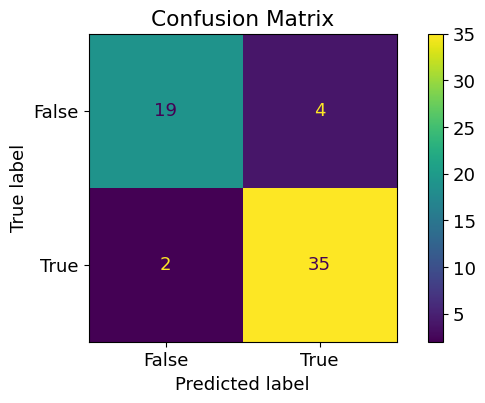

In [54]:
result = (y_pred_val >= 0.5)
ConfusionMatrixDisplay.from_predictions(y_val, result)
plt.title("Confusion Matrix")
plt.show()

Again, let's use different threshold values and check how the model performs.

In [55]:
# Iterate over different threshold values, calculate precision and recall 
thresholds = np.arange(0, 1.01, 0.01)

scores = []
for t in thresholds:
    result = (y_pred_val >= t)
    fn = confusion_matrix(y_val, result)[1][0]
    precision = precision_score(y_val, result, zero_division=0).round(3)
    recall = recall_score(y_val, result, zero_division=0).round(3)
    scores.append((t, fn, precision, recall))

df_scores = pd.DataFrame(scores, columns=["threshold", "FN", "precision", "recall"])
df_scores

,threshold,FN,precision,recall
0,0.00,0,0.617,1.000
1,0.01,0,0.617,1.000
2,0.02,0,0.617,1.000
3,0.03,0,0.617,1.000
4,0.04,0,0.617,1.000
...,...,...,...,...
96,0.96,36,1.000,0.027
97,0.97,36,1.000,0.027
98,0.98,36,1.000,0.027
99,0.99,37,0.000,0.000


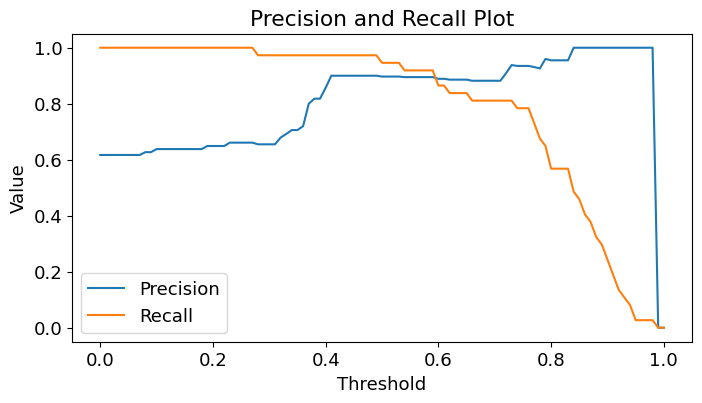

In [56]:
# Draw precision and recall plot
plt.plot(df_scores["threshold"], df_scores["precision"], label="Precision")
plt.plot(df_scores["threshold"], df_scores["recall"], label="Recall")
plt.title("Precision and Recall Plot")
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.legend()
plt.draw()

For this model also, we get ideal threshold 0.6.

### 4.3.5 Final Model

In [57]:
# Train the model again with tuned parameters
rf_final = RandomForestClassifier(
    n_estimators = 100,
    criterion="gini", 
    max_depth=None, 
    max_features=5, 
    min_samples_leaf=5, 
    min_samples_split=7, 
    random_state=1,
    n_jobs=-1
)
rf_final.fit(X_train, y_train)

# Predit using validation dataset
y_pred = rf_final.predict_proba(X_val)[:, 1]
result = (y_pred >= 0.6)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred).round(3)}")

Validation dataset AUC: 0.931


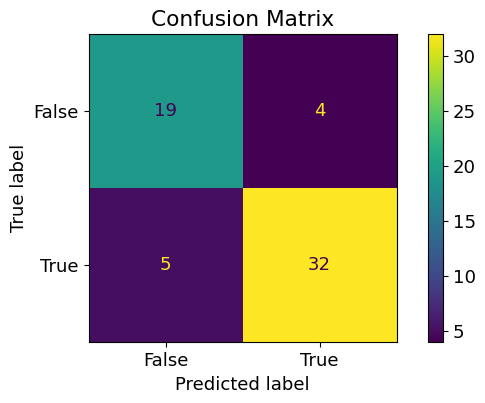

In [58]:
# Calculate the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, result)
plt.title("Confusion Matrix")
plt.show()

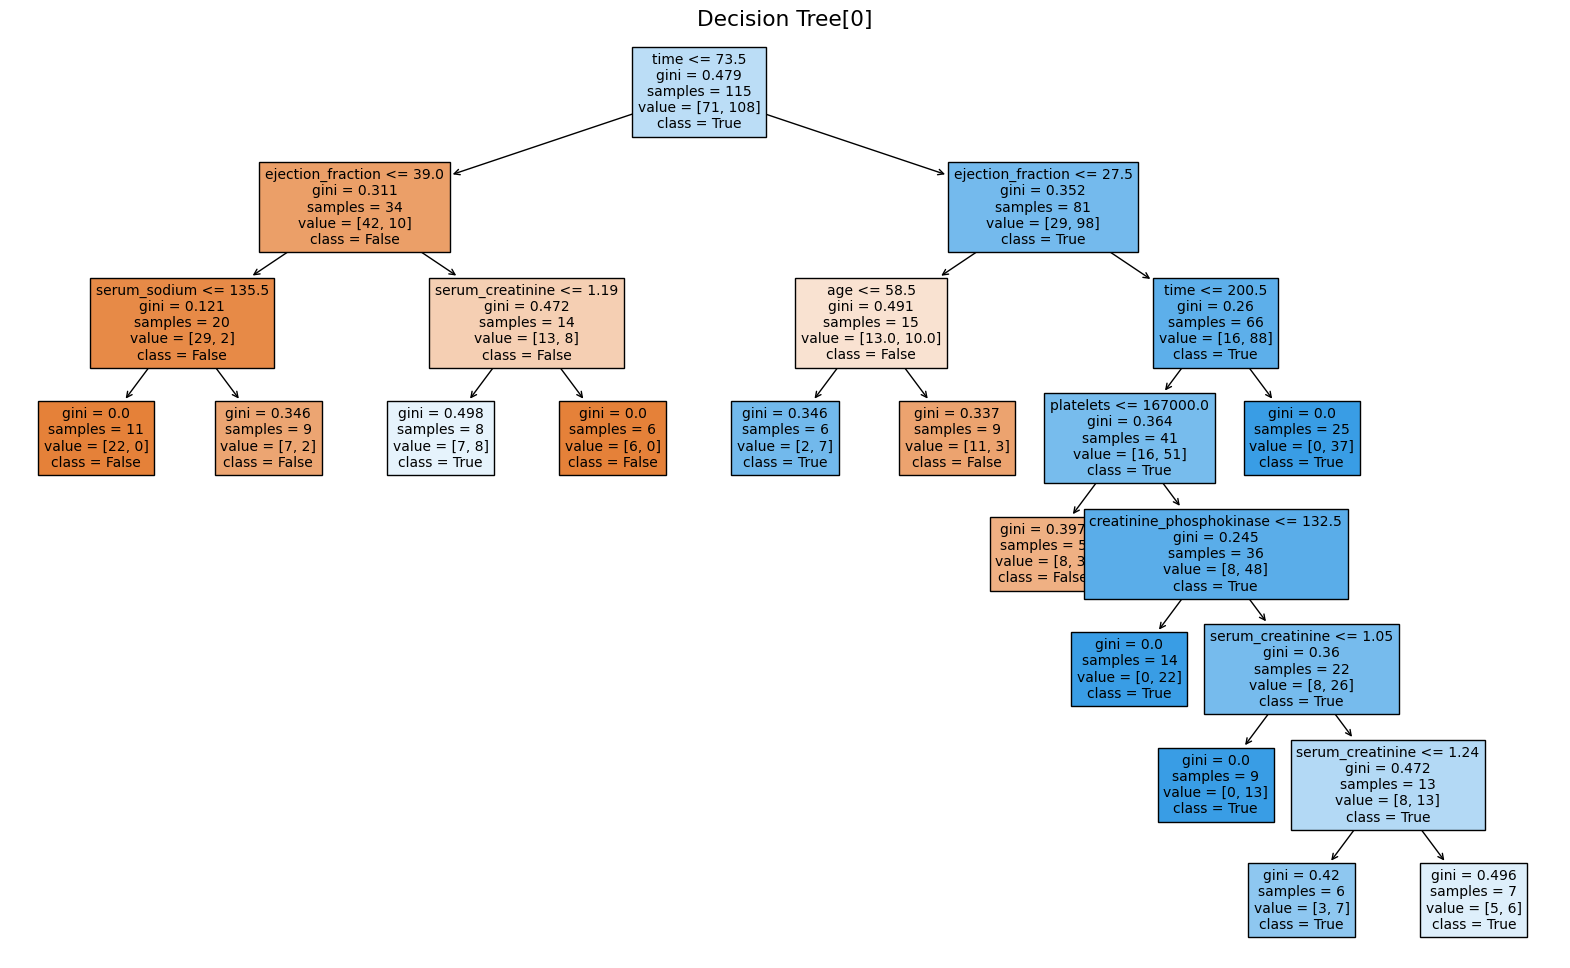

In [59]:
# Plot the first decision tree from the final random forest model
feature_names = list(dv.get_feature_names_out())
class_names = list(map(str, df["DEATH_EVENT"].unique()))

plt.figure(figsize=(20,12), dpi=100)
plot_tree(rf_final.estimators_[0], feature_names=feature_names, class_names=class_names, filled=True, fontsize=10)
plt.title("Decision Tree[0]")
plt.show()
# Double click to zoom the plot

In [60]:
# Check important features
importances = rf_final.feature_importances_
importances

array([0.06655927, 0.00855022, 0.03639059, 0.00492193, 0.11228448,
       0.00398161, 0.05687279, 0.16861571, 0.06144726, 0.00818504,
       0.00453026, 0.00479628, 0.46286456])

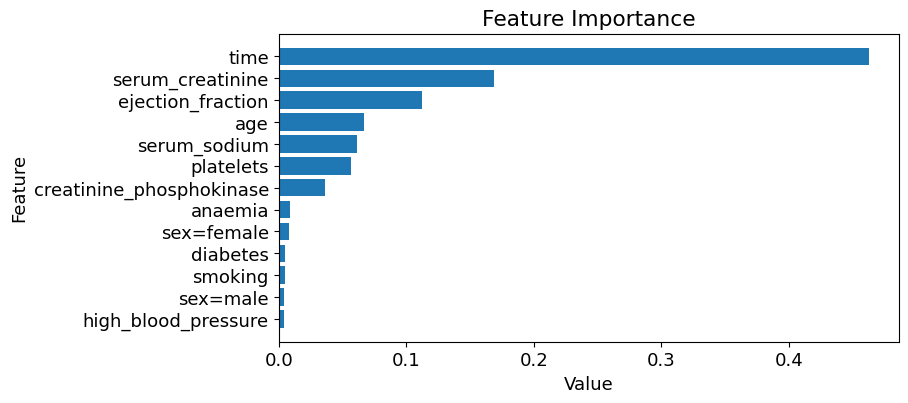

In [61]:
# Draw the important featuers in a plot
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(dv.get_feature_names_out()[indices])
plt.title("Feature Importance")
plt.xlabel("Value")
plt.ylabel("Feature")
plt.show()

Here again, we can see that `time` is the most important feature followed by `serum_sodium` and `ejection_fraction`.

## 4.4 XGBoost Model

### 4.4.1 Base Model

In [63]:
features = dv.get_feature_names_out()
features = features.tolist()  # Convert NumPy array to a list of strings

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)


In [64]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [65]:
# Train the model with training dataset using default parameters
xgb_params = {
    "objective": "binary:logistic",
    "seed": 1
}
xgb_model_base = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

[0]	train-logloss:0.50100	val-logloss:0.57691
[5]	train-logloss:0.25525	val-logloss:0.42812
[10]	train-logloss:0.15426	val-logloss:0.40248
[15]	train-logloss:0.10998	val-logloss:0.37307
[20]	train-logloss:0.08449	val-logloss:0.35958
[25]	train-logloss:0.07029	val-logloss:0.33782
[30]	train-logloss:0.06130	val-logloss:0.34110
[35]	train-logloss:0.05505	val-logloss:0.33549
[40]	train-logloss:0.05039	val-logloss:0.33292
[45]	train-logloss:0.04700	val-logloss:0.33360
[50]	train-logloss:0.04458	val-logloss:0.33513
[55]	train-logloss:0.04222	val-logloss:0.33617
[60]	train-logloss:0.03985	val-logloss:0.33827
[65]	train-logloss:0.03738	val-logloss:0.34045
[70]	train-logloss:0.03550	val-logloss:0.33906
[75]	train-logloss:0.03400	val-logloss:0.34055
[80]	train-logloss:0.03280	val-logloss:0.34214
[85]	train-logloss:0.03177	val-logloss:0.34755
[90]	train-logloss:0.03086	val-logloss:0.35275
[95]	train-logloss:0.03000	val-logloss:0.35154
[99]	train-logloss:0.02937	val-logloss:0.35386


In [66]:
# Predict using validation dataset
y_pred = xgb_model_base.predict(dval)
result = (y_pred >= 0.5)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred).round(3)}")

Validation dataset AUC: 0.928


In [67]:
# Predict using training dataset
y_pred = xgb_model_base.predict(dtrain)
result = (y_pred >= 0.5)
print(f"Training dataset AUC: {roc_auc_score(y_train, y_pred).round(3)}")

Training dataset AUC: 1.0


Again the model is overfitted for training dataset. Let's try to improve this by tuning default parameters.

### 4.4.2 Tune Hyperparameters

In [68]:
# Define the parameter grid
param_grid = {
    "learning_rate": np.arange(0, 1, 0.03),
    'n_estimators': [50, 100, 200, 300],
    "objective": ["binary:logistic"],
    "seed": [1]
}

In [69]:
# Define the grid search model
xgb_model = xgb.XGBClassifier(random_state=1, n_jobs=-1, use_label_encoder=False)
search_xgb = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    n_jobs=-1
)

# Train the grid search model with training dataset
search_xgb.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=1, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
       0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63,
       0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96,
       0.99]),
                         'n_estimators': [50, 100, 200, 300],
                         'objective': ['binary:logistic'], 'seed': [1]})

In [70]:
# Get the tuned hyperparameters from the grid search model
print(f"Best parameter (CV Score = {search_xgb.best_score_.round(3)}):")
print(search_xgb.best_params_)

Best parameter (CV Score = 0.804):
{'learning_rate': 0.6, 'n_estimators': 50, 'objective': 'binary:logistic', 'seed': 1}


Now, let's create a tuned model with best hyperparameters.

### 4.4.3 Tuned Model

In [71]:
# Train the model with training dataset using default parameters
xgb_params = {
    "eta": 0.899,
    "objective": "binary:logistic",
    "seed": 1
}
xgb_model_tuned = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

[0]	train-logloss:0.34717	val-logloss:0.47853
[5]	train-logloss:0.10374	val-logloss:0.39052
[10]	train-logloss:0.05644	val-logloss:0.35493
[15]	train-logloss:0.04551	val-logloss:0.34533
[20]	train-logloss:0.03776	val-logloss:0.35137
[25]	train-logloss:0.03325	val-logloss:0.36350
[30]	train-logloss:0.02944	val-logloss:0.36567
[35]	train-logloss:0.02725	val-logloss:0.37426
[40]	train-logloss:0.02550	val-logloss:0.37349
[45]	train-logloss:0.02436	val-logloss:0.37951
[50]	train-logloss:0.02330	val-logloss:0.38124
[55]	train-logloss:0.02242	val-logloss:0.38609
[60]	train-logloss:0.02157	val-logloss:0.38869
[65]	train-logloss:0.02084	val-logloss:0.38763
[70]	train-logloss:0.02052	val-logloss:0.39211
[75]	train-logloss:0.02024	val-logloss:0.39723
[80]	train-logloss:0.01984	val-logloss:0.40310
[85]	train-logloss:0.01966	val-logloss:0.40686
[90]	train-logloss:0.01938	val-logloss:0.40960
[95]	train-logloss:0.01909	val-logloss:0.41576
[100]	train-logloss:0.01894	val-logloss:0.41642
[105]	train-lo

In [72]:
# Predict using validation dataset
y_pred_val = xgb_model_tuned.predict(dval)
result = (y_pred_val >= 0.5)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred_val).round(3)}")

Validation dataset AUC: 0.922


In [73]:
# Predict using training dataset
y_pred_train = xgb_model_tuned.predict(dtrain)
result = (y_pred_train >= 0.5)
print(f"Training dataset AUC: {roc_auc_score(y_train, y_pred_train).round(3)}")

Training dataset AUC: 1.0


### 4.4.4 Model Interpretation

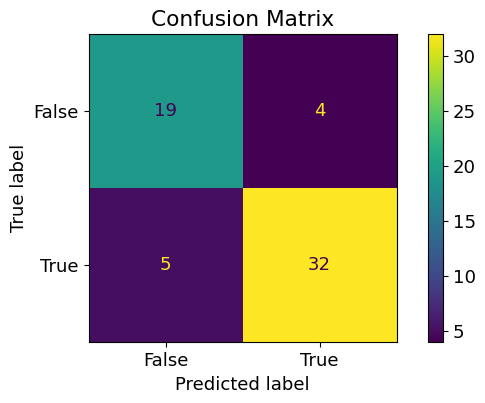

In [74]:
result = (y_pred_val >= 0.5)
ConfusionMatrixDisplay.from_predictions(y_val, result)
plt.title("Confusion Matrix")
plt.show()

Again, let's use different threshold values and check how the model performs.

In [75]:
# Iterate over different threshold values, calculate precision and recall 
thresholds = np.arange(0, 1.01, 0.01)

scores = []
for t in thresholds:
    result = (y_pred_val >= t)
    fn = confusion_matrix(y_val, result)[1][0]
    precision = precision_score(y_val, result, zero_division=0).round(3)
    recall = recall_score(y_val, result, zero_division=0).round(3)
    scores.append((t, fn, precision, recall))

df_scores = pd.DataFrame(scores, columns=["threshold", "FN", "precision", "recall"])
df_scores

,threshold,FN,precision,recall
0,0.00,0,0.617,1.000
1,0.01,0,0.685,1.000
2,0.02,0,0.698,1.000
3,0.03,0,0.725,1.000
4,0.04,0,0.740,1.000
...,...,...,...,...
96,0.96,12,0.893,0.676
97,0.97,12,0.893,0.676
98,0.98,16,0.955,0.568
99,0.99,19,1.000,0.486


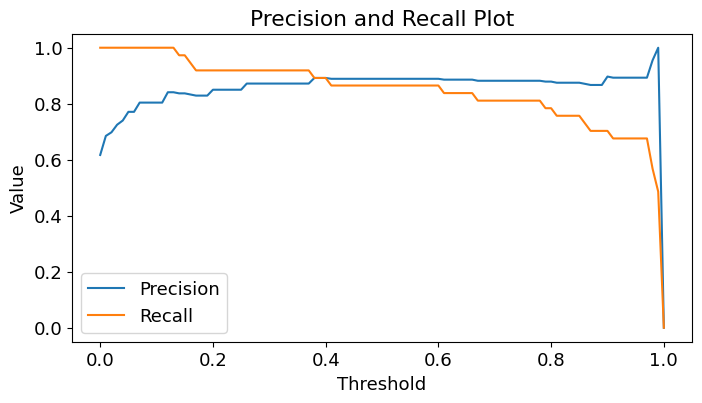

In [76]:
# Draw precision and recall plot
plt.plot(df_scores["threshold"], df_scores["precision"], label="Precision")
plt.plot(df_scores["threshold"], df_scores["recall"], label="Recall")
plt.title("Precision and Recall Plot")
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.legend()
plt.draw()

For this model, ideal threshold is 0.4.

### 4.4.5 Final Model

In [77]:
# Train the model with training dataset using default parameters
xgb_params = {
    "eta": 0.899,
    "objective": "binary:logistic",
    "seed": 1
}
xgb_model_final = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

# Predict using validation dataset
y_pred = xgb_model_final.predict(dval)
result = (y_pred >= 0.4)
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred).round(3)}")

[0]	train-logloss:0.34717	val-logloss:0.47853
[5]	train-logloss:0.10374	val-logloss:0.39052
[10]	train-logloss:0.05644	val-logloss:0.35493
[15]	train-logloss:0.04551	val-logloss:0.34533
[20]	train-logloss:0.03776	val-logloss:0.35137
[25]	train-logloss:0.03325	val-logloss:0.36350
[30]	train-logloss:0.02944	val-logloss:0.36567
[35]	train-logloss:0.02725	val-logloss:0.37426
[40]	train-logloss:0.02550	val-logloss:0.37349
[45]	train-logloss:0.02436	val-logloss:0.37951
[50]	train-logloss:0.02330	val-logloss:0.38124
[55]	train-logloss:0.02242	val-logloss:0.38609
[60]	train-logloss:0.02157	val-logloss:0.38869
[65]	train-logloss:0.02084	val-logloss:0.38763
[70]	train-logloss:0.02052	val-logloss:0.39211
[75]	train-logloss:0.02024	val-logloss:0.39723
[80]	train-logloss:0.01984	val-logloss:0.40310
[85]	train-logloss:0.01966	val-logloss:0.40686
[90]	train-logloss:0.01938	val-logloss:0.40960
[95]	train-logloss:0.01909	val-logloss:0.41576
[100]	train-logloss:0.01894	val-logloss:0.41642
[105]	train-lo

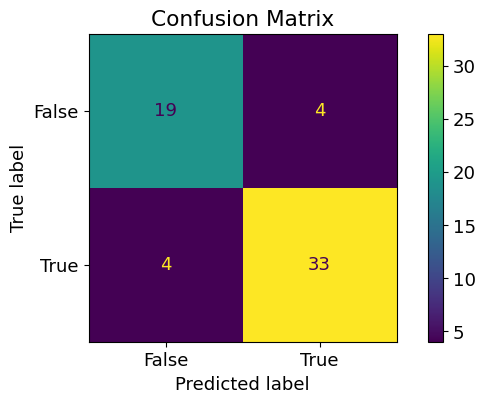

In [78]:
ConfusionMatrixDisplay.from_predictions(y_val, result)
plt.title("Confusion Matrix")
plt.show()

# 5. Choosing the Best Model

From the table below, we can see that RandomForestClassifier has the highest AUC score followd by XGBoost. For our particular problem, the **False Negative** value is very important. It means that the model predicted that the person will not die, but actually the person died. That's why we want lower FN value in our model.

| Model | AUC | False Negative | False Positive |
| --- | --- | --- | --- |
| LogisticRegression | 0.84 | 6 | 7 |
| DecisionTreeClassifier | 0.858 | 10 | 6 |
| RandomForestClassifier | 0.931 | 5 | 4 |
| XGBoost | 0.925 | 4 | 4 |

Based on AUC score, both RandomForestClassifier and XGboost did a good job. But then if we consider FN values also, then XGBoost performed slightly better. So, we can choose XGboost as the best model to solve the problem.

**Best Model: XGBoost**

# 6. Predict on Test Dataset

In [79]:
# Train the model with training dataset using default parameters
xgb_params = {
    "eta": 0.899,
    "objective": "binary:logistic",
    "seed": 1
}
xgb_model_final = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

# Predict using test dataset
y_pred = xgb_model_final.predict(dtest)
result = (y_pred >= 0.4)
print(f"Validation dataset AUC: {roc_auc_score(y_test, y_pred).round(3)}")

[0]	train-logloss:0.34717	val-logloss:0.47853
[5]	train-logloss:0.10374	val-logloss:0.39052
[10]	train-logloss:0.05644	val-logloss:0.35493
[15]	train-logloss:0.04551	val-logloss:0.34533
[20]	train-logloss:0.03776	val-logloss:0.35137
[25]	train-logloss:0.03325	val-logloss:0.36350
[30]	train-logloss:0.02944	val-logloss:0.36567
[35]	train-logloss:0.02725	val-logloss:0.37426
[40]	train-logloss:0.02550	val-logloss:0.37349
[45]	train-logloss:0.02436	val-logloss:0.37951
[50]	train-logloss:0.02330	val-logloss:0.38124
[55]	train-logloss:0.02242	val-logloss:0.38609
[60]	train-logloss:0.02157	val-logloss:0.38869
[65]	train-logloss:0.02084	val-logloss:0.38763
[70]	train-logloss:0.02052	val-logloss:0.39211
[75]	train-logloss:0.02024	val-logloss:0.39723
[80]	train-logloss:0.01984	val-logloss:0.40310
[85]	train-logloss:0.01966	val-logloss:0.40686
[90]	train-logloss:0.01938	val-logloss:0.40960
[95]	train-logloss:0.01909	val-logloss:0.41576
[100]	train-logloss:0.01894	val-logloss:0.41642
[105]	train-lo

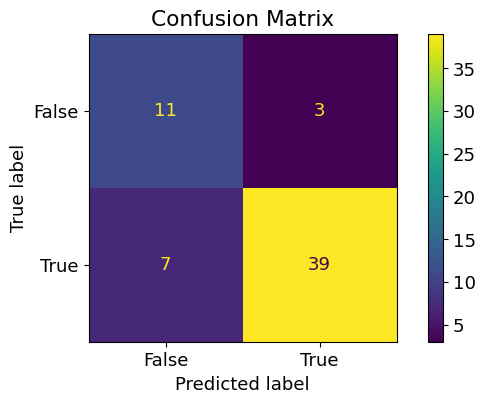

In [80]:
ConfusionMatrixDisplay.from_predictions(y_test, result)
plt.title("Confusion Matrix")
plt.show()

We got a good AUC score 0.939 on test dataset. But the False Negative value is slightly higher than validation dataset.

Submitted by- Shweta Kanungo